### CIVIS DATA MODELLING - 

In [14]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
import matplotlib.pyplot as plt
import array
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import (RandomTreesEmbedding, RandomForestClassifier,
                              GradientBoostingClassifier)
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.model_selection import cross_val_score

In [15]:
dfo = pd.read_csv('./data/xaxis/train.csv')
dfo_test = pd.read_csv('./data/xaxis/test.csv')
print(dfo.columns)

#print(dfo.describe())
dfo.groupby('response').size()

Index(['placement', 'position', 'browser', 'carrier', 'domain', 'supply_type',
       'language', 'region', 'os_extended', 'publisher', 'device_model',
       'device_type', 'user_day', 'user_hour', 'size', 'response'],
      dtype='object')


response
0    159270
1       726
dtype: int64

In [16]:
#Look for duplicated rows and drop them
print(dfo.columns)

#Some websites are NaN so dropping these
#df.dropna(inplace=True)
dfo['domain'].fillna('Unknown',inplace=True)

#Undersample the background to 60/40 ratio of non-click/click
df0 = dfo[(dfo['response']==0)]
df1 = dfo[dfo['response']==1]
print(len(df1))
seed = 99
df0 = df0.sample(frac=0.007,random_state=seed)
print(len(df0))
df = pd.concat([df0,df1])
print(len(df))

Index(['placement', 'position', 'browser', 'carrier', 'domain', 'supply_type',
       'language', 'region', 'os_extended', 'publisher', 'device_model',
       'device_type', 'user_day', 'user_hour', 'size', 'response'],
      dtype='object')
726
1115
1841


In [17]:
#Get Some info about df
Nsig=len(df[df['response']==1].index)
Nbkg=len(df[df['response']==0].index)
ratio=Nsig/(Nbkg)
print(ratio)

0.6511210762331838


In [18]:
for name in df.columns:
    print(name,len(df[name].unique()))


placement 258
position 3
browser 18
carrier 5
domain 232
supply_type 3
language 15
region 5
os_extended 49
publisher 112
device_model 85
device_type 6
user_day 7
user_hour 20
size 5
response 2


              placement  position   browser   carrier  supply_type  language  \
placement      1.000000 -0.025223  0.013594  0.005171     0.267584  0.028182   
position      -0.025223  1.000000  0.007848 -0.039822    -0.256168  0.128469   
browser        0.013594  0.007848  1.000000 -0.024135    -0.234108  0.014306   
carrier        0.005171 -0.039822 -0.024135  1.000000     0.031554  0.016640   
supply_type    0.267584 -0.256168 -0.234108  0.031554     1.000000  0.003453   
language       0.028182  0.128469  0.014306  0.016640     0.003453  1.000000   
region        -0.078830 -0.002538  0.000216  0.195262    -0.028810 -0.020443   
os_extended   -0.024715 -0.008102  0.129368  0.053739    -0.151541 -0.095313   
publisher      0.727270 -0.039439 -0.005997  0.050242     0.360373  0.025881   
device_model   0.071600 -0.070442  0.048440  0.024592     0.093477 -0.012955   
user_day       0.275776 -0.080864 -0.127226  0.018573     0.325717  0.015609   
user_hour      0.077829 -0.006892  0.045

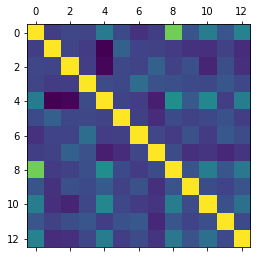

In [19]:
#Correlation Matrix
print(df.corr())
plt.matshow(df.corr())
plt.show()

In [20]:
#Function to create dictionary between domain and weekly-views for that domain
def getdict(data):
    data.loc[data['user_hour']>0,'user_hour']=1

    grouped = data.groupby(['domain','user_day'],as_index=False).agg({'user_hour':np.sum})
    grouped = grouped.groupby(['domain'],as_index=False).agg({'user_hour':np.sum})
    grouped['weekviews'] = grouped['user_hour']
    
    mydict=grouped.set_index(['domain']).to_dict()['weekviews']
    return mydict

In [21]:
'''
Perform various steps to transform the data
'''
def transform(data,mydict):
    #Create a new category domctr (Domain CTR)
    data['domctr']=0.0
    data['domctr'] = data['domain'].replace(mydict)

    #create dummies for categorical variables    
    myarr=data['device_type'].unique()
    data[myarr]=pd.get_dummies(data['device_type'])
    data.drop('device_type',axis=1,inplace=True)
    data = data.drop('phone',1) 

    myarr1=data['size'].unique()
    data[myarr1]=pd.get_dummies(data['size'])
    print(myarr1)
    data.drop('size',axis=1,inplace=True)
    data = data.drop('300x250',1) 
    
    data.loc[(data.user_day >=0) & (data.user_day<5),'user_day']=0
    data.loc[(data.user_day >5),'user_day']=1
    
    #Preprocessing
    X_scaled= preprocessing.scale(data['publisher'])
    data['publisher']=X_scaled

    X_scaled= preprocessing.scale(data['placement'])
    data['placement']=X_scaled

    X_scaled= preprocessing.scale(data['os_extended'])
    data['os_extended']=X_scaled
    
    return(data)

In [22]:
print(df['user_hour'].unique())
dict = getdict(df)
newdf = transform(df,dict)

#Check if anything wierd happened during dictionary translation
print(newdf['domctr'].isnull().any().any())
newdf.dropna(inplace=True)
#newdf['domctr']=np.float32(newdf['domctr'])

df = newdf
#print(df.isnull().any().any())
newdf.columns
#df.columns

[ 0  9 15 16 10 13  8  3 18  6  2 14 17 11  7  5 12  1 19  4]
['320x50' '300x250' '160x600' '728x90' '300x600']
False


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


Index(['placement', 'position', 'browser', 'carrier', 'domain', 'supply_type',
       'language', 'region', 'os_extended', 'publisher', 'device_model',
       'user_day', 'user_hour', 'response', 'domctr', 'pc & other devices',
       'tablet', 'game console', 'set top box', 'tv', '320x50', '160x600',
       '728x90', '300x600'],
      dtype='object')

In [23]:
dict1 = getdict(dfo_test)
dfo_test = transform(dfo_test,dict1)
newdf = dfo_test
print(newdf['domctr'].isnull().any().any())
newdf.dropna(inplace=True)
#newdf['domctr']=np.float32(newdf['domctr'])
dfo_test = newdf

['320x50' '300x250' '160x600' '728x90' '300x600']
True


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [24]:
dfo_test['domctr']=np.float32(dfo_test['domctr'])

In [25]:
#dfo_test.dropna(inplace=True)
#dfo_test.isnull().any()
print(dfo_test.isnull().any().any())

False


In [26]:
#Created my own test Sample
dfx = df
Y = dfx['response']
X = dfx.drop('response',1)

df_train, df_test, dfy_train, y_test = train_test_split(X,Y, test_size=0.20, random_state=0)

In [27]:
dfx.head()

,placement,position,browser,carrier,domain,supply_type,language,region,os_extended,publisher,...,domctr,pc & other devices,tablet,game console,set top box,tv,320x50,160x600,728x90,300x600
146472,-0.591600,1,8,1,myanimelist.net,1,1,0,0.646695,-0.779363,...,30,0,0,0,0,0,0,0,1,0
3765,0.398746,1,8,1,cari.com.my,0,0,0,-0.976030,0.373234,...,22,0,0,0,0,0,0,0,0,0
34450,-1.377952,1,8,284,russiadefence.net,1,1,0,0.311847,-1.509724,...,1,0,1,0,0,0,0,0,1,0
87808,-0.734539,0,21,283,kissasian.com,1,1,0,0.672452,-0.569565,...,376,0,1,0,0,0,0,0,1,0
80278,-0.469670,0,9,1,mp4upload.com,1,1,0,0.930028,-0.569565,...,7,0,0,0,1,0,0,0,0,0


In [2251]:
#dropcols=['user_hour','carrier','position','placement','browser','domain','region','language','728x90','device_model','tablet']
dropcols=['user_hour','carrier','position','placement',
          'browser','domain','region','language','728x90',
          'device_model','tablet','320x50','160x600','pc & other devices']
keepcols=['placement','os_extended','domctr','publisher','user_day','device_model']

In [2252]:
df_train = df_train.drop('domain',1) #Training Sample
df_test = df_test.drop('domain',1) #My Test Sample 
dfo_test = dfo_test.drop('domain',1) #Given Test Sample

In [2253]:
#Create the features data set
T=dfy_train
F=df_train

In [2254]:
# A simple logistic Regression
ind = len(F.columns)
print(ind)
F.insert(ind,'intercept',1)
logit_mod = sm.Logit(T, F[F.columns])
results = logit_mod.fit()
results.summary()

22
         Current function value: 0.585296
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               response   No. Observations:                 1472
Model:                          Logit   Df Residuals:                     1449
Method:                           MLE   Df Model:                           22
Date:                Fri, 02 Feb 2018   Pseudo R-squ.:                  0.1297
Time:                        17:29:49   Log-Likelihood:                -861.56
converged:                      False   LL-Null:                       -989.94
                                        LLR p-value:                 6.367e-42
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
placement              0.7491      0.117      6.392      0.000       0.519       0.979
position              -0.3470      0.158     -2.198      0.028      -0.656      -0.038
browser               -0.0354      0.013     -2.696      0.007      -0.061      -0.010
carrier               -0.0002      0.001     -0.372      0.710      -0.001       0.001
supply_type            0.4234      0.136      3.104      0.002       0.156       0.691
language              -0.0339      0.022     -1.567      0.117      -0.076       0.009
region                 0.1105      0.081      1.371      0.170      -0.048       0.269
os_extended           -0.1083      0.071     -1.530      0.126      -0.247       0.030
publisher             -0.3254      0.118     -2.759      0.006      -0.557      -0.094
device_model        8.006e-07   2.11e-06      0.379      0.705   -3.34e-06    4.95e-06
user_day               0.0836      0.032      2.647      0.008       0.022       0.146
user_hour             -0.0219      0.404     -0.054      0.957      -0.813       0.769
domctr                 0.0004      0.000      0.912      0.362      -0.000       0.001
pc & other devices     0.0576      1.463      0.039      0.969      -2.809       2.924
tablet                 0.4288      0.147      2.911      0.004       0.140       0.718
game console         -19.3196   1.22e+04     -0.002      0.999    -2.4e+04     2.4e+04
set top box           -0.1653      0.248     -0.667      0.505      -0.651       0.320
tv                    -1.9774      0.824     -2.400      0.016      -3.593      -0.362
320x50                 0.7513      0.342      2.200      0.028       0.082       1.421
160x600               -0.9470      0.778     -1.217      0.224      -2.473       0.578
728x90                 0.1068      0.134      0.797      0.425      -0.156       0.369
300x600               -0.2136      0.289     -0.740      0.459      -0.780       0.352
intercept             -0.8121      0.452     -1.798      0.072      -1.698       0.073
======================================================================================
"""

In [2255]:
F = F.drop('intercept',1)

In [2256]:
#Decision Tree Classifieer
y = T
X = F

In [2257]:
#X.replace([np.inf, -np.inf], np.nan)
#print(np.array(X['domctr'][1:500]))
#DecisionTreeClaissifer
dt = DecisionTreeClassifier(min_samples_split=5, random_state=99)
dt.fit(X, y)
scores = cross_val_score(dt, X, y).mean()
print(scores)

0.703129805894


In [2258]:
#Logistic Regression
from sklearn.pipeline import make_pipeline
rt = RandomTreesEmbedding(max_depth=5, n_estimators=10,
    random_state=0)

rt_lm = LogisticRegression()
pipeline = make_pipeline(rt, rt_lm)
pipeline.fit(X,y)
scores = cross_val_score(rt_lm, X, y).mean()
print(scores)

0.690897377281


0.735734375216
Index(['placement', 'position', 'browser', 'carrier', 'supply_type',
       'language', 'region', 'os_extended', 'publisher', 'device_model',
       'user_day', 'user_hour', 'domctr', 'pc & other devices', 'tablet',
       'game console', 'set top box', 'tv', '320x50', '160x600', '728x90',
       '300x600'],
      dtype='object')
Feature ranking:
1. feature 0 (0.207498)
2. feature 7 (0.164982)
3. feature 12 (0.119850)
4. feature 2 (0.064524)
5. feature 9 (0.063515)
6. feature 8 (0.061943)
7. feature 10 (0.059666)
8. feature 4 (0.054241)
9. feature 3 (0.050490)
10. feature 5 (0.034030)
11. feature 20 (0.028098)
12. feature 14 (0.017520)
13. feature 6 (0.016225)
14. feature 1 (0.016146)
15. feature 16 (0.014597)
16. feature 11 (0.010018)
17. feature 21 (0.006428)
18. feature 18 (0.005452)
19. feature 19 (0.002255)
20. feature 17 (0.001387)
21. feature 13 (0.000654)
22. feature 15 (0.000482)


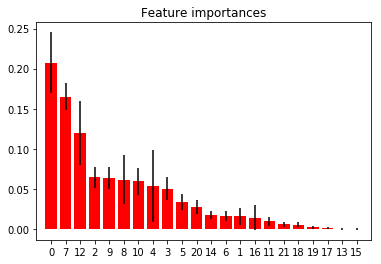

In [2259]:
#Random rf Classifier
rf = RandomForestClassifier(min_samples_split=3)
rf.fit(X,y)
scores = cross_val_score(rf, X, y).mean()
print(scores)

print(X.columns)
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the rf
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [2260]:
X_test=df_test
#Feature Importance
features=X_test.columns
print(features)
print(dt.feature_importances_)

Index(['placement', 'position', 'browser', 'carrier', 'supply_type',
       'language', 'region', 'os_extended', 'publisher', 'device_model',
       'user_day', 'user_hour', 'domctr', 'pc & other devices', 'tablet',
       'game console', 'set top box', 'tv', '320x50', '160x600', '728x90',
       '300x600'],
      dtype='object')
[ 0.27612282  0.01435295  0.06025189  0.04249882  0.02192753  0.02602828
  0.02436807  0.12820457  0.03164686  0.10119949  0.05750329  0.01004022
  0.15028698  0.00230679  0.01685913  0.          0.00344928  0.00054876
  0.00501192  0.00319267  0.01652915  0.00767052]


In [2261]:
#Predict and get the confusion Matrix
X_test = df_test
preds = dt.predict(X_test, check_input=True)
print(confusion_matrix(y_test, preds))

#RandomForest
preds3 = rf.predict(X_test)
print(confusion_matrix(y_test,preds3))

#Logistcregression
preds4 = pipeline.predict(X_test)
print(confusion_matrix(y_test,preds4))

[[163  67]
 [ 40  99]]
[[179  51]
 [ 38 101]]
[[193  37]
 [ 69  70]]


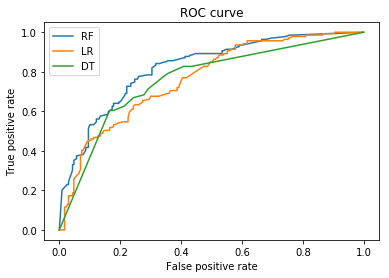

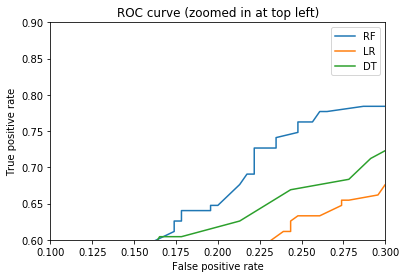

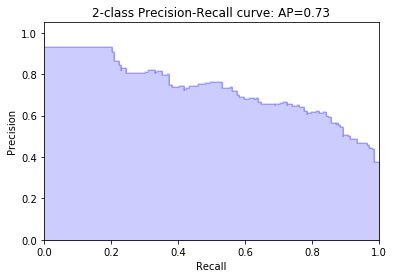

In [2262]:
#Plot ROC curve and Precision-Recall
from sklearn.metrics import roc_curve

y_pred_rf = rf.predict_proba(X_test)[:, 1]
y_pred_lg = pipeline.predict_proba(X_test)[:, 1]
y_pred_dt = dt.predict_proba(X_test)[:, 1]

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
fpr_lg, tpr_lg, _ = roc_curve(y_test, y_pred_lg)
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_dt)

# The random forest model by itself
plt.figure(1)
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_lg, tpr_lg, label='LR')
plt.plot(fpr_dt, tpr_dt, label='DT')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

plt.figure(2)
plt.xlim(0.1, 0.3)
plt.ylim(0.6, 0.9)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_lg, tpr_lg, label='LR')
plt.plot(fpr_dt, tpr_dt, label='DT')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

y_score=y_pred_rf
average_precision = average_precision_score(y_test, y_score)
precision, recall, _ = precision_recall_curve(y_test, y_score)
plt.step(recall, precision, color='b', alpha=0.2,where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
plt.show()

In [2263]:
print('Precision:',precision_score(y_test, preds3))
print('Recall:',recall_score(y_test, preds3))
print('Accuracy:',accuracy_score(y_test,preds3))

Precision: 0.664473684211
Recall: 0.726618705036
Accuracy: 0.758807588076


In [2283]:
def write(data):
    final = data
    final['prob']=0.0
    final['prob']=y_pred_axis
    final.head()
    final.to_csv('test_prob.csv',index=False)
#final = pd.concat([dfo_test,yarr],axis=1)

In [2266]:
#plt.hist(y_pred_grd)
X_test2 = dfo_test
y_pred_axis = rf.predict_proba(X_test2)[:,1]

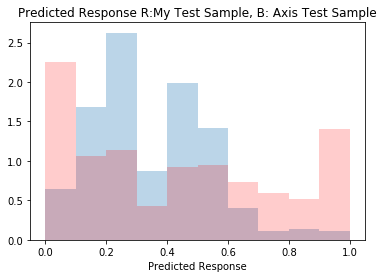

In [2279]:
plt.hist(y_pred_axis,alpha=0.3,normed=1)
plt.hist(y_pred_rf,color='r',alpha=0.2,normed=1)
plt.xlabel('Predicted Response')
plt.title('Predicted Response R:My Test Sample, B: Axis Test Sample')
plt.show()


In [2284]:
write(dfo_test)

In [2285]:
check = pd.read_csv('./test_prob.csv')
check.head()

,placement,position,browser,carrier,supply_type,language,region,os_extended,publisher,device_model,...,pc & other devices,set top box,tv,game console,tablet,320x50,160x600,728x90,300x600,prob
0,-0.391414,1,9,1,1,1,0,0.861971,-0.074557,301,...,0,1,0,0,0,0,0,1,0,0.566667
1,0.670259,2,8,282,0,0,0,0.583132,0.590764,100234,...,0,1,0,0,0,0,0,0,0,0.400000
2,0.825863,0,8,1,0,1,0,-0.988505,0.700774,0,...,1,0,0,0,0,1,0,0,0,0.516667
3,-0.544617,0,14,1,1,1,0,-0.456176,-0.400001,100499,...,0,0,1,0,0,0,0,1,0,0.300000
4,0.670259,0,8,1,0,2,0,0.228246,0.590764,0,...,1,0,0,0,0,0,0,0,0,0.183333
